<a href="https://colab.research.google.com/github/aliahalotaibi73/week6_exercises/blob/main/Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [508]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [509]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, SimpleRNN, Dense
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [510]:
# because date time is object we need to convert it to datetime type
df = pd.read_csv('/content/Traffic Data.csv', parse_dates=['date_time'], index_col=['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [511]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [512]:
df.sort_index(inplace=True)

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [513]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


* from the info function we can regonize that there is missing values in column traffic_volumn

In [514]:
df.duplicated().sum()

18

In [515]:
df.drop_duplicates(inplace=True)

In [516]:
df.duplicated().sum()

0

In [517]:
df['traffic_volume'].fillna(df['traffic_volume'].mean(), inplace=True)

In [518]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19982 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19982 non-null  float64
 1   temp                 19982 non-null  float64
 2   rain_1h              19982 non-null  float64
 3   snow_1h              19982 non-null  float64
 4   clouds_all           19982 non-null  int64  
 5   weather_main         19982 non-null  object 
 6   weather_description  19982 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


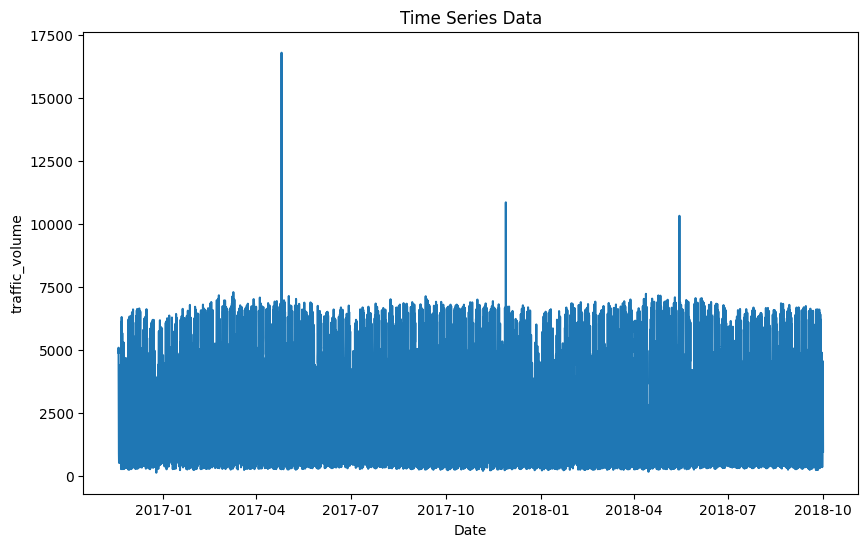

In [519]:
plt.figure(figsize=(10,6))
plt.plot(df['traffic_volume'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('traffic_volume')
plt.show()

* in seasonal_decompose I choose to use model additive because multiplcative is not appropriate for zero and negative values.

In [520]:
result = seasonal_decompose(df['temp'],
                            model ='additive', period=7)

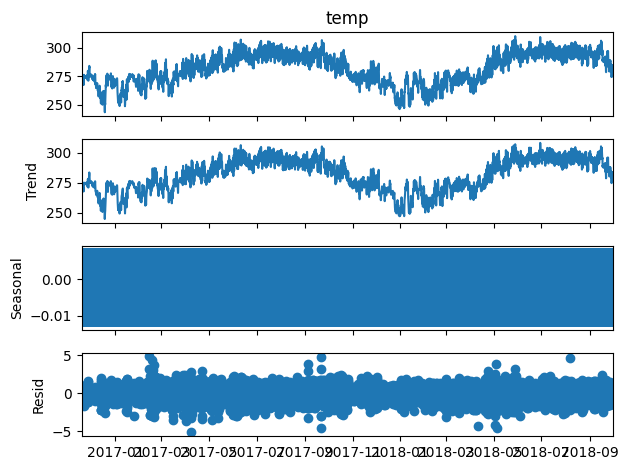

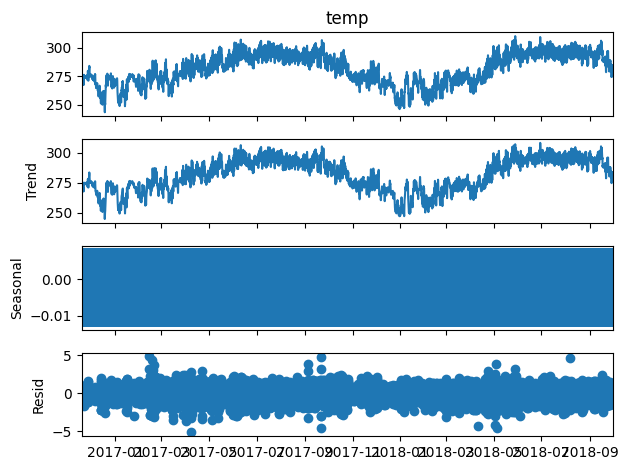

In [521]:
result.plot()

In [522]:
result_2 = seasonal_decompose(df['traffic_volume'],
                            model ='additive', period=365)

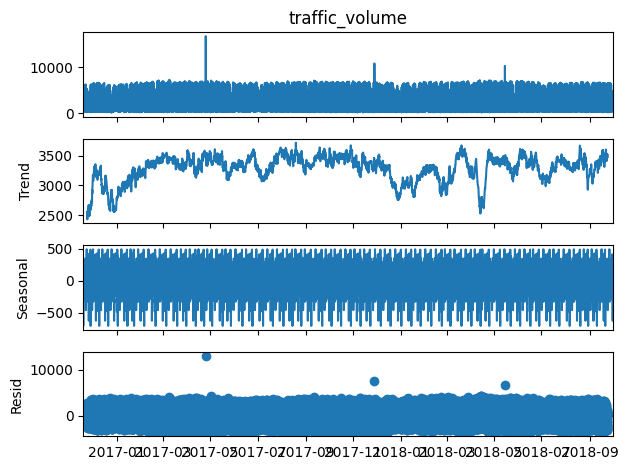

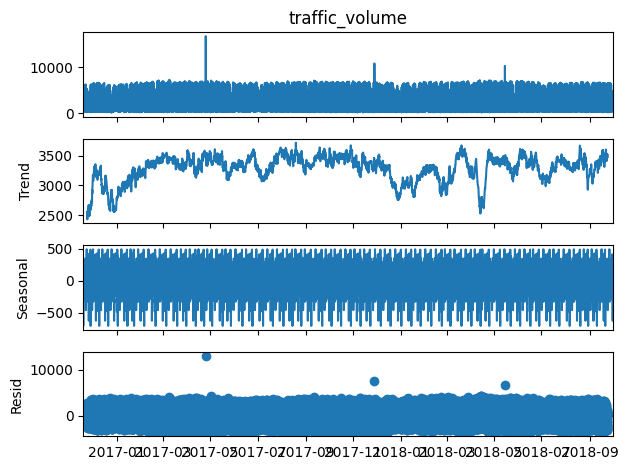

In [523]:
result_2.plot()

* I dropped some columns that I do not need

In [524]:
df = df.drop(['temp','snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'traffic_volume'], axis=1)

In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19982 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19982 non-null  float64
 1   temp                 19982 non-null  float64
 2   rain_1h              19982 non-null  float64
 3   snow_1h              19982 non-null  float64
 4   clouds_all           19982 non-null  int64  
 5   weather_main         19982 non-null  object 
 6   weather_description  19982 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [526]:
#moving averages

df['moving averages_8'] = df['traffic_volume'].rolling(window=8).mean()

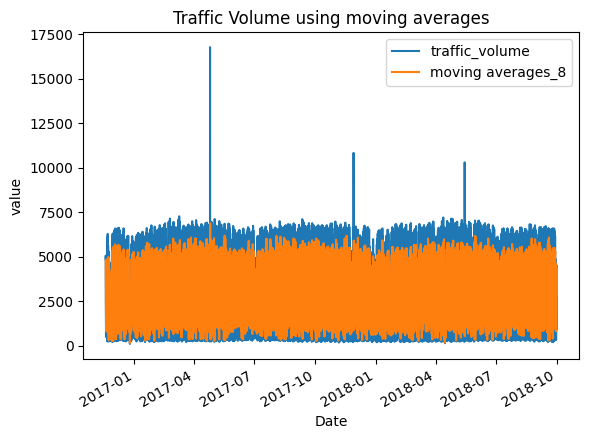

In [527]:
df[['traffic_volume', 'moving averages_8']].plot()
plt.title('Traffic Volume using moving averages')
plt.xlabel('Date')
plt.ylabel('value')
plt.show()

In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19982 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19982 non-null  float64
 1   temp                 19982 non-null  float64
 2   rain_1h              19982 non-null  float64
 3   snow_1h              19982 non-null  float64
 4   clouds_all           19982 non-null  int64  
 5   weather_main         19982 non-null  object 
 6   weather_description  19982 non-null  object 
 7   moving averages_8    19975 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.4+ MB


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [529]:
#shift method
df['prev_traffic_volume'] = df['traffic_volume'] - df['traffic_volume'].shift(1)

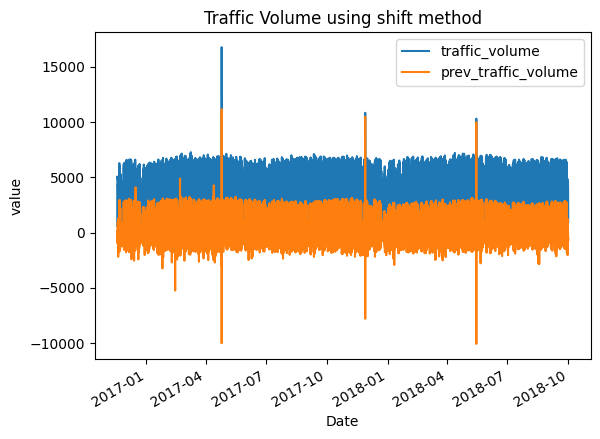

In [530]:
df[['traffic_volume', 'prev_traffic_volume']].plot()
plt.title('Traffic Volume using shift method')
plt.xlabel('Date')
plt.ylabel('value')
plt.show()

In [531]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19982 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19982 non-null  float64
 1   temp                 19982 non-null  float64
 2   rain_1h              19982 non-null  float64
 3   snow_1h              19982 non-null  float64
 4   clouds_all           19982 non-null  int64  
 5   weather_main         19982 non-null  object 
 6   weather_description  19982 non-null  object 
 7   moving averages_8    19975 non-null  float64
 8   prev_traffic_volume  19981 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.5+ MB


In [532]:
df['prev_traffic_volume'].fillna(df['prev_traffic_volume'].mean(), inplace=True)
df['moving averages_8'].fillna(df['moving averages_8'].mean(), inplace=True)

In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19982 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19982 non-null  float64
 1   temp                 19982 non-null  float64
 2   rain_1h              19982 non-null  float64
 3   snow_1h              19982 non-null  float64
 4   clouds_all           19982 non-null  int64  
 5   weather_main         19982 non-null  object 
 6   weather_description  19982 non-null  object 
 7   moving averages_8    19982 non-null  float64
 8   prev_traffic_volume  19982 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.5+ MB


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [535]:
df.values

array([[ 0.00000000e+00, -1.96086282e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -6.22000000e+02],
       [ 0.00000000e+00, -7.09000000e+02],
       [ 0.00000000e+00, -4.96000000e+02]])

In [536]:
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [537]:
train_data.shape , test_data.shape

((15985, 2), (3997, 2))

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [538]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [539]:
# prepare data for LSTM model

def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [540]:
X_train, Y_train = create_dataset(train_data_scaled, 12)
X_test, Y_test = create_dataset(test_data_scaled, 12)

In [541]:
X_train.shape

(15972, 12, 2)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [546]:
modelRNN = Sequential()
modelRNN.add(SimpleRNN(units=50, return_sequences=True, input_shape=(12,2)))
modelRNN.add(SimpleRNN(units=50, return_sequences=True))
modelRNN.add(Dense(units=1))

In [547]:
modelRNN.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_26 (SimpleRNN)            │ (None, 12, 50)              │           2,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_27 (SimpleRNN)            │ (None, 12, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 12, 1)               │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,751 (30.28 KB)

 Trainable params: 7,751 (30.28 KB)

 Non-trainable params: 0 (0.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [548]:
modelRNN.compile(optimizer='adam',loss='mean_squared_error')

In [549]:
modelRNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=64, verbose=1)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0068 - val_loss: 0.9086
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4198e-05 - val_loss: 0.9038
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1489e-05 - val_loss: 0.9007
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.1463e-06 - val_loss: 0.8991
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.8075e-06 - val_loss: 0.8989
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.4878e-06 - val_loss: 0.8992
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9925e-05 - val_loss: 0.8970
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 9.6793e-06 - val_loss: 0.8984
Epoch 9/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.0384e-05 - val_loss: 0.8959
Epoch 10/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.6613e-06 - val_loss: 0.8942
Epoch 11/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.3426e-06 - val_loss: 0.8927
Epoch 12

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [550]:
predictions_RNN = modelRNN.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [551]:
mse = math.sqrt(mean_squared_error(Y_test, predictions_RNN))
print("RNN Model evaluation:", mse)

ValueError: Found array with dim 3. None expected <= 2.

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [552]:
modelLSTM = Sequential()

In [553]:
modelLSTM.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
modelLSTM.add(LSTM(32))
modelLSTM.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [554]:
modelLSTM.compile(optimizer='adam', loss='mean_squared_error')

In [555]:
modelLSTM.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1.4857e-04 - val_loss: 0.7956
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 9.4308e-08 - val_loss: 0.7960
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4.4347e-08 - val_loss: 0.7964
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.7727e-08 - val_loss: 0.7967
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 6.6479e-09 - val_loss: 0.7970
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3.2114e-09 - val_loss: 0.7971
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2.6387e-09 - val_loss: 0.7972
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.8887e-09 - val_loss: 0.7972
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.7125e-09 - val_loss: 0.7973
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1.0356e-09 - val_loss: 0.7973


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [556]:
predictions_LSTM = modelRNN.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [557]:
predictions_LSTM.shape

(3984, 12, 1)

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [558]:
mse2 = math.sqrt(mean_squared_error(Y_test, predictions_LSTM))
print("RNN Model evaluation:", mse2)

ValueError: Found array with dim 3. None expected <= 2.

In [559]:
Y_test_rescaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 3))), axis=1))[:, 0]
#LSTM Inverse
predictions_rescaled_LSTM = scaler.inverse_transform(np.concatenate((predictions_LSTM, np.zeros((predictions_LSTM.shape[0], 3))), axis=1))[:, 0]

ValueError: operands could not be broadcast together with shapes (3984,4) (2,) (3984,4) 

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

* 1. I prefer to use fillna instead of drop row with missing values especially if the missing values is alot. I choose MinMaxScaler because I want the data to be in fixed range.


* 2. I try to apply Feature Engineering to enhancing model accuracy but I think I apply it in wrong way.

* 3. for model architecture I do the default and for number of number of neurons I read in one of the website said it is butter to start with numberlike 64 and in the next layer put 32 and the 16 and so on.

* 4. I choose batch size 64 because it  suitable for  given dataset. for optimizer I choose Adam as default.

* 4. I choose mean_squared_error because it is suitable for time series.